In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.datasets as datasets

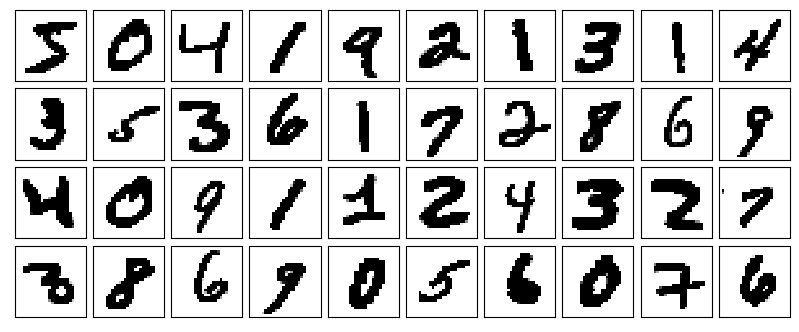

In [10]:
mnist_trainset = datasets.MNIST(root='./data', train=True,  download=True, transform=None)
plot_digits(mnist_trainset.train_data.reshape(-1,28*28), w=28)

This jupyter notebook can be found here: [https://github.com/cagatayyildiz/pca-ae-vae-diffmodels](https://github.com/cagatayyildiz/pca-ae-vae-diffmodels).

# 0. References

This presentation contains many ideas, re-phrased sentences and screenshots from the following resources:

- [Chris Bishop's Pattern Recognition and Machine Learning book](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/) (PCA-1)
- [Kevin Murphy's Probabilistic Machine Learning: An Introduction book](https://probml.github.io/pml-book/book1.html) (PCA-2, AE)
- [Probabilistic principal component analysis](http://www.cs.columbia.edu/~blei/seminar/2020-representation/readings/TippingBishop1999.pdf) (PCA-3)
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) (PCA digit example)
- [Probabilistic Non-linear Principal Component Analysis with Gaussian Process Latent Variable Models](https://www.jmlr.org/papers/volume6/lawrence05a/lawrence05a.pdf) (PCA-3)

- [Understanding the deep learning book](https://udlbook.github.io/udlbook/) (VAE)


$\newcommand{\N}{\mathcal{N}}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\U}{\mathcal{U}}$

# 1. Principle component analysis

Imagine a dataset $X \in \R^{N\times D}$ with $N$ data points, each in a $D$-dimensional space.
Often times, $D$ is so big that visualizing data points is difficult.
Further, the data points often include redundant features which we do not want to visualize.
For this, we would like to "summarize" or "explain" the data in a lower dimensional space.

Let $x_n \in \R^D$ denote the $n$'th data point (row) in our data matrix. 
Let's assume data to be centered:

$$ \bar{x} = \frac{1}{N} \sum_n x_n = 0$$

We would like to approximate each $x_n$ by a low dimensional representation, $z_n \in \R^q$.
We will start by linear projections of data points into the lower-dimensional space, which leads to an algorithm called principle component analysis.
We describe PCA from three different perspectives.

### 1.1. Maximum variance perspective
One may describe the goal of the dimensionality reduction as maximizing the variance of $z$'s as this would be the informative scenario.
To begin with, consider the projection onto a one-dimensional space ($q=1$). 
Let's define the direction of this space by a vector $w_1 \in \R^D$.
Of course, we are only interested in the direction, hence $\|w_1\| = w_1^\top w_1$=1.
Here, $w_1$ would simply project each data point $x_n$ into the point $w_1^\top x_n$.
Let's write the variance of the projected points:

\begin{align}
\max_{w_1} ~~ \frac{1}{N} \sum_n \left( w_1^\top x_n - w_1^\top \bar{x} \right)^2 
&= \frac{1}{N} \sum_n w_1^\top  \left( x_n - \bar{x} \right) \left( x_n - \bar{x} \right)^\top w_1  \\
&= w_1^\top \underbrace{\left(\frac{1}{N} \sum_n \left( x_n - \bar{x} \right) \left( x_n - \bar{x} \right)^\top \right)}_{S} w_1 \\
&= w_1^\top S w_1,
\end{align}

where S is simply the data covariance matrix.
We also have the constraint, that is, $w_1$ is a unit vector (this is convenient, otherwise $w_1^\top S w_1 → \infty$).
We add this as a constraint with Lagrange multiplier $\lambda_1$ and solve the following optimization problem:

\begin{align}
  \max_{w_1} ~~ &\L = w_1^\top S w_1 + \lambda_1 \left( 1-w_1^\top w_1 \right) \\
  \frac{\partial \L}{\partial w_1} &= S w_1 - \lambda_1 w_1 = 0 \\
  S w_1 &= \lambda_1 w_1 → w_1^\top S w_1 = \lambda_1,
 \end{align}

which says that $w_1$ must be an eigenvector of $S$, and $\lambda_1$ is the corresponding eigenvalue.
This eigenvector is the first principal component.
Other principal components can similarly be found by choosing each new direction to be that which maximizes the projected variance amongst all possible directions orthogonal to those already considered.

Let's generate a simple dataset for PCA illustration

\begin{align}
  w_1, w_2 &\sim S^1 \\
  z_n &\sim \N(0,1) \\
  \epsilon_n  &\sim \N(0,0.1^2) \\
  x_n &= Wz_n + \epsilon_n
\end{align}

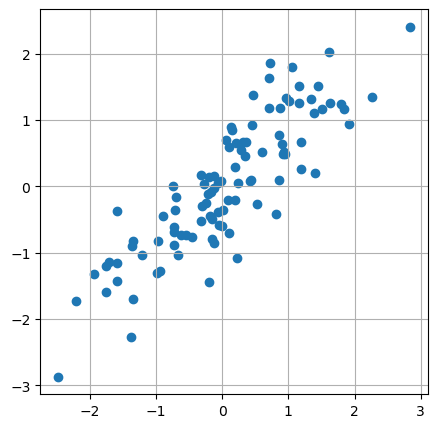

In [3]:
plt.figure(1,(5,5))
N = 100
# x_n = U @ z_n, z_n ~ N(0,I)
U = np.random.rand(2, 2)*2 - 1
U = U / ((U**2).sum(1,keepdims=True)**(0.5))
Z = np.random.randn(2, N)
X = (U @ Z).T # N,2
# X = X + np.random.randn(N,2)/10
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.grid()

Explained variance [0.93004858 0.06995142]
First PC [0.71631083 0.69778134]


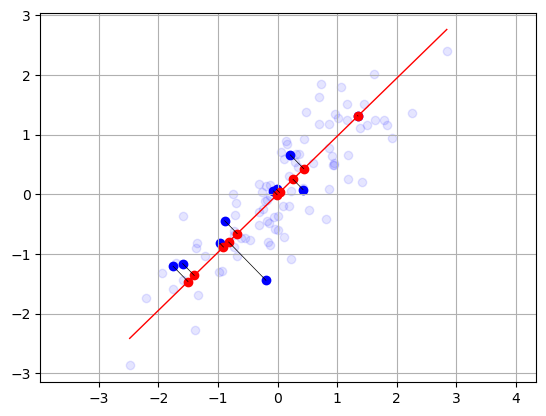

In [4]:
X_mean = X.mean(0) # N,2
Xc = X - X_mean    # mean centered data
S  = Xc.T @ Xc / N # covar matrix
V,U = np.linalg.eig(S) # eigenvectors are in the columns
# sort 
idx = np.argsort(V)[::-1]
V,U = V[idx],U[:,idx]
u1,u2 = U[:,0],U[:,1]
print('Explained variance', V/V.sum())
print('First PC', u1)

# plot Nplot data points
Nplot = 10
plt_idx = np.random.permutation(np.arange(N))[:Nplot]
plt.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.1)
plt.scatter(X[plt_idx, 0], X[plt_idx, 1], color='blue')
# plot the PC
x_grid = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_grid = u1[1] * x_grid / u1[0]
plt.plot(x_grid, y_grid, 'r', lw=1)
# plot the corresponding embeddings
z1 = X[plt_idx] @ u1
plt.plot(z1*u1[0], z1*u1[1], 'or')
# plot the mappings
for n,idx in enumerate(plt_idx):
    plt.plot([X[idx,0],z1[n]*u1[0]], [X[idx,1],z1[n]*u1[1]], '-k', lw=.5)
plt.grid()
plt.axis('equal');



### 1.2. Minimum error formulation

Now we approach the problem from another perspective.
Our goal is again to obtain $q$-dimensional latent or "hidden” values $z_n \in \R^q$ using basis $w_1,\ldots,w_q$ where $w_i \in \R^D$.
In other words, we wish

\begin{align}
  x_n \approx \tilde{x}_n =  \sum_{i=1}^q z_{i,n} w_i 
\end{align}

If we collect all basis in a $[D,q]$ matrix $W=\{w_1,\ldots,w_q \}$ and latents in a $[N,q]$ matrix $Z=\{z_1,\ldots,z_N \}$, our objective becomes 


\begin{align}
  \min ~\L(W,Z) &= \| X - \tilde{X} \|_2^2 = \frac{1}{N} \sum_n \| x_n - Wz_n \|_2^2 
\end{align}

We start by considering a single basis $w_1$.

\begin{align}
  \min ~ \L &= \frac{1}{N} \sum_n (x_n - w_1z_{n1})^\top (x_n - w_1z_{n1}) \\
  &= \frac{1}{N} \sum_n x_n^\top x_n - 2x_n^\top w_1 z_{n1} + z_{n1}^\top w_1^\top w_1 z_{n1} \\
  &= \frac{1}{N} \sum_n x_n^\top x_n - 2x_n^\top w_1 z_{n1} + z_{n1}^\top  z_{n1}
\end{align}

We first maximize wrt $z_{n1}$:

\begin{align}
  \frac{\partial \L}{\partial z_{n1}} &= - 2x_n^\top w_1 + 2z_{n1} = 0 \\
  z_{n1} &= x_n^\top w_1
\end{align}

Then we plug this into the loss:

\begin{align}
  \min_{w_1} ~ \L &= \frac{1}{N} \sum_n x_n^\top x_n - 2z_{n1}^\top  z_{n1} + z_{n1}^\top z_{n1} \\
  &= \frac{1}{N} \sum_n x_n^\top x_n - z_{n1}^\top  z_{n1} \\
  &= \text{const} - \frac{1}{N} \sum_n w_1^\top x_n x_n^\top w_1 \\
  &= \text{const} - w_1^\top \left( \frac{1}{N} \sum_n x_n x_n^\top \right) w_1 \\
  &= \text{const} - w_1^\top S w_1,
\end{align}

which brings us to the same optimization problem as above.
In a recursive manner, we solve the following problem afterwards:

\begin{align}
  \min ~ \L &= \frac{1}{N} \sum_n (x_n - w_1z_{n1} - w_2z_{n2})^\top (x_n - w_1z_{n1} - w_1z_{n1} - w_2z_{n2}),
\end{align}

this time with given $X,w_1,\text{ and, }Z_1$, as well as the orthogonality constraint $w_1^\top w_2=0$.

Now, let's see a simple higher-dimensional PCA example.
We start by loading an image dataset.

Data shape (1797, 64)


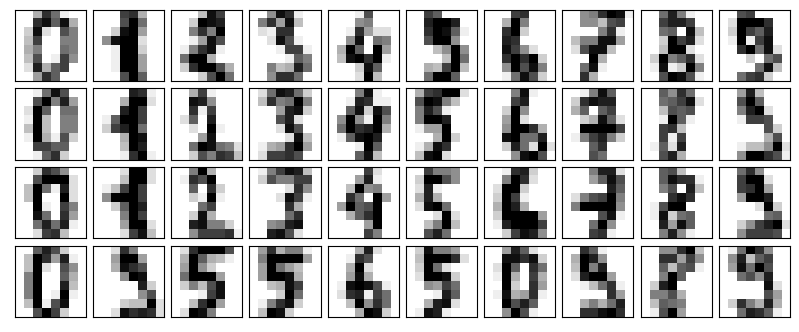

In [5]:
digits = load_digits()
X = digits.data
print('Data shape', X.shape)


def plot_digits(data, w=8):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(w, w),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
plot_digits(digits.data)

Next, let's embed the data into the 2D space by PCA.

Data shape   (1797, 64)
Latent shape (1797, 2)


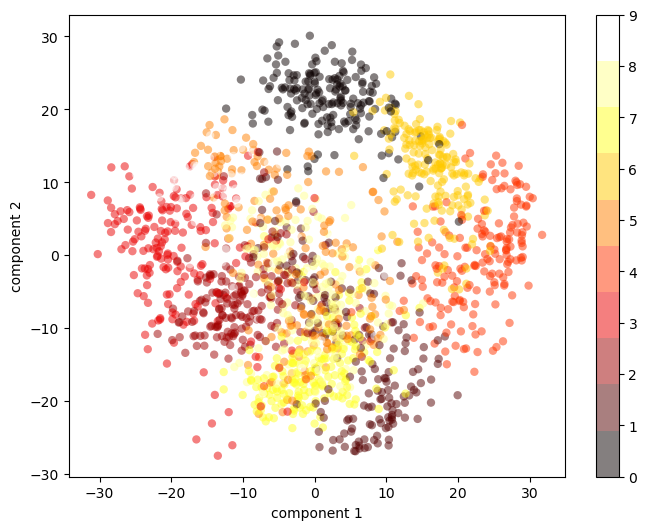

In [6]:
pca = PCA(2)  # project from 64 to 2 dimensions
Z = pca.fit_transform(X)
print('Data shape  ', X.shape)
print('Latent shape', Z.shape)

plt.figure(1,(8,6))
plt.scatter(Z[:, 0], Z[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('hot', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

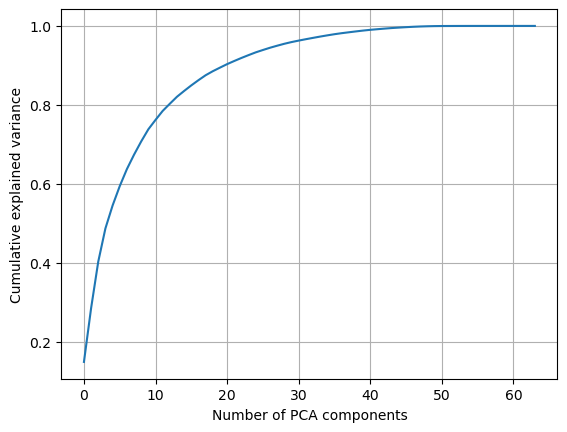

In [7]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.grid();

$\newcommand{\d}{\text{d}}$

### 1.3. Probabilistic PCA

Finally, we express PCA from a probabilistic perspective.
We start by considering low dimensional, Gaussian distributed latent variables: 

\begin{align}
  z_n &\sim \N(0,I) 
\end{align}

As before, we assume that the data points $x_n$ are linear transformations of the hidden variables:

\begin{align}
  x_n &= Wz_n + \mu + \epsilon_n
\end{align}

where $\epsilon_n$ is unobserved noise:

\begin{align}
  \epsilon_n  &\sim \N(0,\sigma^2 I) 
\end{align}

Since Gaussians are closed under linear operations, we obtain the following likelihood:

\begin{align}
  x_n | z_n \sim \N(Wz_n + \mu, \sigma^2 I)
\end{align}

Note that we are interested in computing the marginal likelihood:

\begin{align}
  p(x_n) &= \int p(x_n,z_n) \d z_n \\
  &= \int p(x_n|z_n) p(z_n) \d z_n \\
  &= \int p(x_n|z_n) p(z_n) \d z_n \\
  &= \int \N(x_n ; Wz_n + \mu, \sigma^2 I) \N(z_n;0,I)  \d z_n \\
  &= \N(\mu, WW^\top + \sigma^2 I)
\end{align}

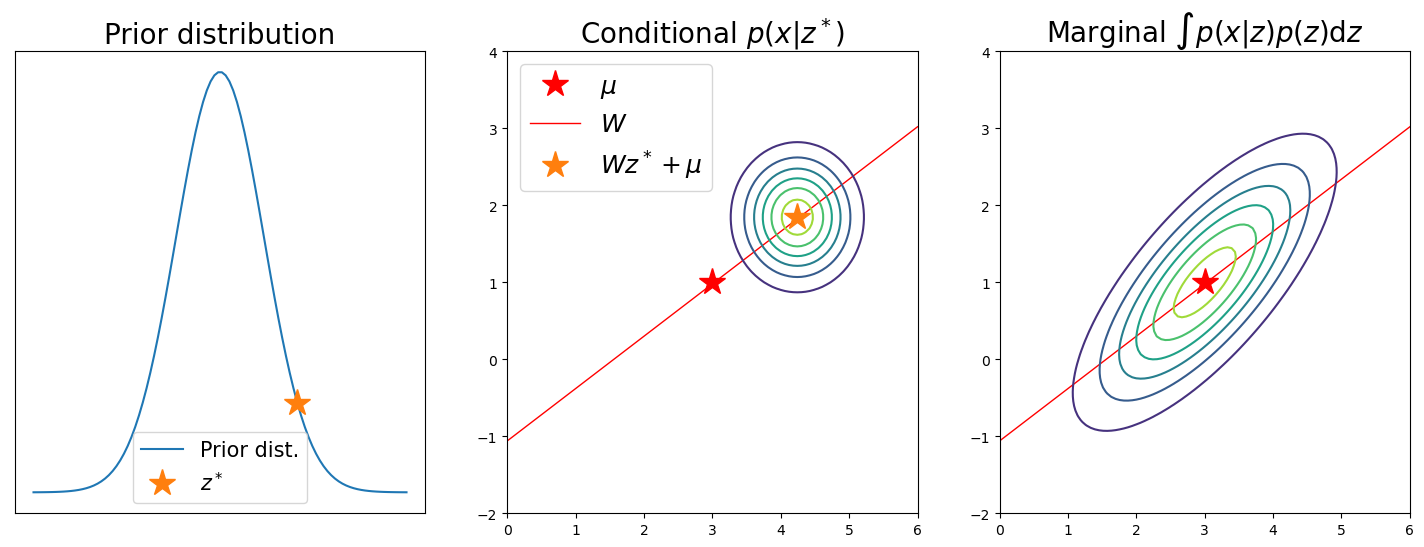

In [8]:
def eval_density(mean,S):
  # mean - [2]
  # S    - [2,2]
  # returns - [Ng,Ng]
    Ng = 100
    Xg,Yg = np.meshgrid(np.linspace(0,6,Ng),np.linspace(-2,4,Ng))
    XY = np.stack([Xg.reshape(-1),Yg.reshape(-1)]).T # N,2
    C = (XY-mean) @ np.linalg.inv(S) @ (XY-mean).T
    lhood = np.exp(-np.diag(C)).reshape(Ng,Ng)
    return Xg,Yg,lhood 

W  = np.array([1.0,0.68])
mu = np.array([3,1])
S  = 0.5 * np.eye(2)

fig,axs = plt.subplots(1,3,figsize=(18,6))
# the prior
xs = np.linspace(-3,3,100)
pr_lhoods = np.exp(-xs**2)
axs[0].plot(xs,pr_lhoods)
axs[0].set_xticks([])
axs[0].set_yticks([])
n = 70
z = xs[n]
axs[0].plot(z,pr_lhoods[n],'*',markersize=20)
axs[0].legend(['Prior dist.', r'$z^*$'],fontsize=15)
axs[0].set_title('Prior distribution',fontsize=20)

# the likelihood of a latent sample
mean_z = W*z + mu
sig_z  = S
Xg_z,Yg_z,lhood_z = eval_density(mean_z,sig_z)
# plot the mean
axs[1].plot(mu[0],mu[1],'r*',ms=20)
# plot w
x_grid = np.linspace(0, 6, 100)
y_grid = W[1] * x_grid / W[0]
y_grid = y_grid - (y_grid[50]-1)
axs[1].plot(x_grid, y_grid, 'r', lw=1)
axs[1].plot(mean_z[0],mean_z[1],'*', color='tab:orange', markersize=20)
axs[1].legend(['$\mu$', '$W$', '$Wz^*+\mu$'],fontsize=18)
axs[1].contour(Xg_z,Yg_z,lhood_z)
axs[1].set_title(r'Conditional $p(x|z^*)$',fontsize=20)


# the marginal
mean_marg = mu
sig_marg  = W.reshape(1,-1) @ W.reshape(-1,1) + S
Xg,Yg,lhood = eval_density(mean_marg,sig_marg)
axs[2].plot(mu[0],mu[1],'r*',ms=20)
axs[2].plot(x_grid, y_grid, 'r', lw=1)
axs[2].contour(Xg,Yg,lhood)
axs[2].set_title(r'Marginal $\int p(x|z)p(z)$d$z$',fontsize=20);

$\newcommand{\tr}{\text{tr}}$

Our objective is to maximize the log of the marginal likelihood wrt the matrix $W$:

\begin{align}
  \log p(X) &= \sum_n \log p(x_n) \\
  &= \sum_n \N(x_n ; \mu, WW^\top + \sigma^2 I) \\
  &= \text{const} -\frac{N}{2} \left( \log |C| + \tr(C^{-1}S)  \right)
\end{align}

with

\begin{align}
  C &= WW^\top + \sigma^2 I \\
  S &= \frac{1}{N} \sum_n \left( x_n - \mu \right) \left( x_n - \mu \right)^\top 
\end{align}

Computing the partial derivative, we have

\begin{align}
  \frac{\partial \log p(X)}{\partial W} = 0 → SC^{-1}W=W
\end{align}

So either of the following must hold:

\begin{align}
  W &= 0 \\
  S &= C \\
  W^* &= U (\Lambda - \sigma^2 I)^{1/2} R 
\end{align}

For the latter case,
- the $q$ column vectors in the $d \times q$ matrix $U$ are the principal eigenvectors of $S$ (the biggest ones, solutions with other eigenvectors are the saddle points.)
- $\Lambda = \text{diag}(\lambda_1,\ldots,\lambda_q)$ contains the corresponding eigenvalues
- $R$ is an arbitrary $q\times q$ orthogonal rotation matrix.

If there is no noise and we set $R=I$, then we obtain
\begin{align}
  W^* &= U \Lambda^{1/2}
\end{align}

Finally, maximizing the marginal likelihood wrt $\sigma$ would give
\begin{align}
  \sigma^2 = \frac{1}{D-q} \sum_{i=1}^{D-q} \lambda_{i+q},
\end{align}
which is the average distortion associated with the discarded dimensions.



![](figs/ppca-em.png)



# 2. From PCA to AE (auto-encoders)

Another interpretation of PCA is a procedure in which we
- first encode the data by a linear transformation $$z_n = \texttt{encode}(x_n;W) = W^\top x_n$$
- then decode using the same projection $$\tilde{x}_n = \texttt{decode}(z_n;W) = Wz_n$$
- finally minimize the error $$\|x_n - \tilde{x}_n \|_2^2$$

An auto-encoder is obtained by replacing this linear transformation with non-linear mappings (neural networks).
As in PCA, the lower dimensional latent representations act as a "bottleneck" layer.

![](figs/ae.png)

The optimization relies on backpropogation, or simply chain rule.
Say our encoder and decoder consist of several layers:

\begin{align}
  \texttt{encoder}(x) &= z = f_n(...(f_2(f_1(x)))) \\
  \texttt{decoder}(z) &= \tilde{x} = g_n(...(g_2(g_1(z))))
\end{align}

Then, the optimization objective can be written as follows:

\begin{align}
  \L &= \| x - g_n(...(g_2(g_1(f_n(...(f_2(f_1(x)))))))) \|_2^2
\end{align}

For gradient computation, we write the above expression verbosely:

\begin{align}
  h_0 &= x \\
  h_i &= f_i(h_{i-1};\theta_i), ~~ \forall i=1,...n \\
  z &= h_n \\
  m_0 &= z \\
  m_i &= g_i(m_{i-1};\psi_i), ~~ \forall i=1,...n \\
  \tilde{x} &= m_n \\
  \L &= \| x - m_n \|_2^2 \\
  \frac{\partial \L}{\partial \psi_n} &= \frac{\partial \L}{\partial m_n} \frac{\partial m_n}{\partial \psi_n} = 2(x - m_n) \frac{\partial m_n }{\partial \psi_n} \\
  \frac{\partial \L}{\partial \psi_{n-1}} &= \frac{\partial \L}{\partial m_n} \frac{\partial m_n}{\partial m_{n-1}} \frac{\partial m_{n-1}}{\partial \psi_{n-1}} = 2(x - m_n) \frac{\partial g_n(m_{n-1};\psi_n)}{\partial \psi_n} \frac{\partial m_{n-1}}{\partial \psi_{n-1}} \\
\end{align}

Now, let's implement an auto-encoder and train it on an image dataset.
First, the dataset.

/Users/cagatay/opt/anaconda3/envs/cl/lib/python3.9/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


MNIST dataset shape torch.Size([60000, 784])


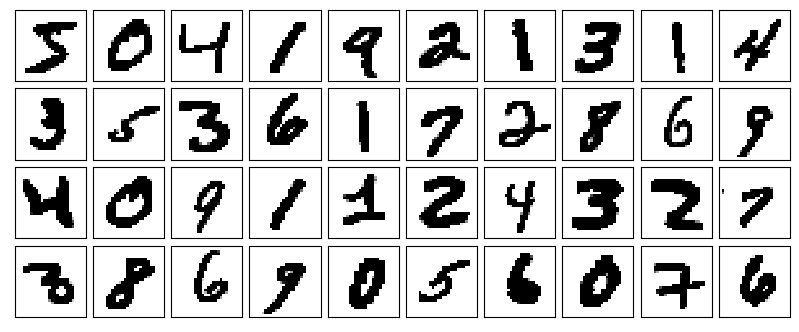

In [9]:
mnist_trainset = datasets.MNIST(root='./data', train=True,  download=True, transform=None)
mnist_testset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X = mnist_trainset.train_data.reshape(-1,28*28)

print('MNIST dataset shape', X.shape)
plot_digits(X, w=28)

Two example auto-encoder implementations:

In [11]:
class MLP_AE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x

class CNN_AE(nn.Module):
    def __init__(self, q=10):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, q)
        )

        self.decoder = nn.Sequential(
            nn.Linear(q, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_tilde = self.decoder(z)
        return x_tilde,z

ae = CNN_AE()
print(ae)

CNN_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=288, out_features=128, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, 

Let's finally train the model:

In [12]:
device = torch.device('cpu')
optimizer = torch.optim.Adam(ae.parameters(), lr=5e-3)

X_torch = torch.tensor(X, dtype=torch.float32)
N = X_torch.shape[0]
batch_size = 100

for epoch in range(10):
    running_loss = 0.0
    random_idx = np.random.permutation(np.arange(N))
    X_mixed = X_torch[random_idx]
    X_mixed = X_mixed.reshape(-1,batch_size,1,28,28)
    for i,minibatch in enumerate(X_mixed):
        optimizer.zero_grad()
        minibatch = minibatch.to(device)
        optimizer.zero_grad()
        predictions = ae(minibatch)[0]
        error = (predictions-minibatch)**2
        loss = error.mean()
        loss.backward()
        optimizer.step()
        if i%100==0:
            print('{:d}-{:.4f}'.format(i,loss))

/var/folders/sy/zbxz8_f94nd0b0d82q4cgk740000gn/T/ipykernel_11023/2263857382.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_torch = torch.tensor(X, dtype=torch.float32)


0-7628.7217
100-5646.8472
200-3003.4219
300-1948.8629
400-1575.8505
500-1530.5507
0-1426.0337
100-1447.8894
200-1293.7833
300-1361.0818
400-1228.8120
500-1261.3850
0-1229.4353
100-1187.4138
200-1221.0444
300-1265.6017
400-1183.0792
500-1159.9485
0-1147.2880
100-1205.6241
200-1135.1644
300-1163.8470
400-1211.2354
500-1103.9478
0-1098.4603
100-1174.6066
200-1068.8463
300-1192.5735
400-1115.0831
500-1018.5432
0-1096.0424
100-994.0508
200-1096.9930
300-1118.5250
400-1076.0570
500-1066.5718
0-1018.2728
100-1058.3573
200-978.0988
300-1051.1539
400-953.9379
500-982.2615
0-991.5519
100-1027.5380
200-965.4827
300-1011.8900
400-959.9594
500-1046.8967
0-927.5007
100-894.6713
200-1034.3939
300-1020.4165
400-1088.9467
500-976.6492
0-952.8253
100-989.9016
200-1000.7675
300-888.2878
400-1060.8571
500-944.5131


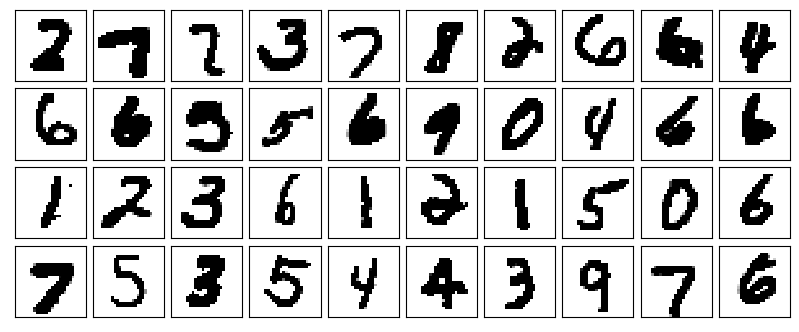

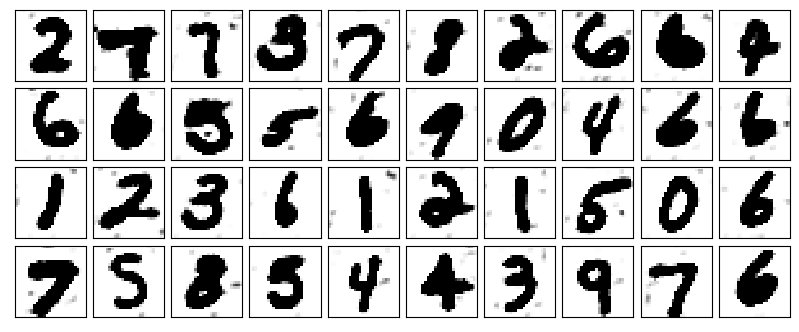

In [13]:
plot_digits(minibatch[:40], w=28)
plot_digits(predictions[:40].detach(), w=28)

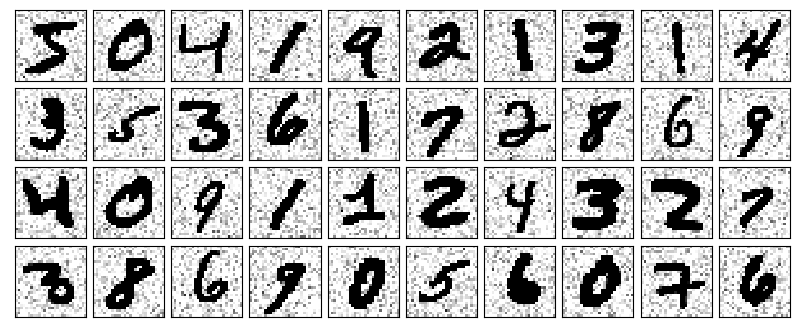

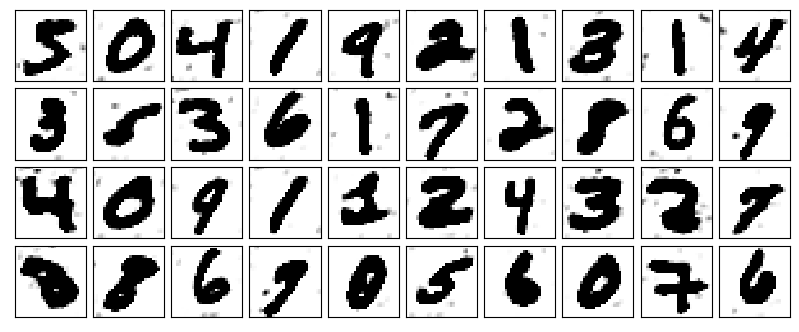

In [16]:
np.random.seed(123)
Xnoisy = np.random.normal(X, 4)
plot_digits(Xnoisy, 28)

# pca = PCA(0.5).fit(Xnoisy)
# print('Number of components ', pca.n_components_)
# print('Explained variance   ', pca.explained_variance_ratio_.sum())

# Z = pca.transform(Xnoisy)
# Xtilde = pca.inverse_transform(Z)
# plot_digits(Xtilde, 28)

Xtilde = ae(torch.tensor(Xnoisy[:40].reshape(40,1,28,28), dtype=torch.float32))[0]
plot_digits(Xtilde.detach(), 28)

# 3. Variational auto-encoders (VAE)

So far, we have seen that a non-linear version of PCA corresponds to an AE.
Let's analyze the same for PPCA by considering the following generative model with a non-linear mapping $f_\phi(\cdot)$ with parameters $\phi$:

\begin{align}
  z_n &\sim \N(0,I)  \\
  \epsilon_n  &\sim \N(0,\sigma^2 I) \\
  x_n | z_n &= f_\phi(z_n) + \epsilon_n \\
  &\sim \N(f_\phi(z_n), \sigma^2 I).
\end{align}

As before, we are interested in the marginal distribution:

\begin{align}
  p(x_n) &= \int p(x_n,z_n) \d z_n \\
  &= \int p(x_n|z_n) p(z_n) \d z_n \\
  &= \int \N(x_n; f_\phi(z_n), \sigma^2 I) \N(z_n;0,I)  \d z_n,
\end{align}
where this time the integral cannot be computed in closed from due to non-linear mapping $f_\phi(z_n)$.
Then, one can see above expression as an infinite weighted sum (i.e., an infinite mixture) of Gaussians with different means, where the weights are $p(z_n)$ and the means are $f_\phi(z_n)$.

#### Discrete mixture of Gaussians:

![](figs/mog.png)

#### Continuous mixture of Gaussians:


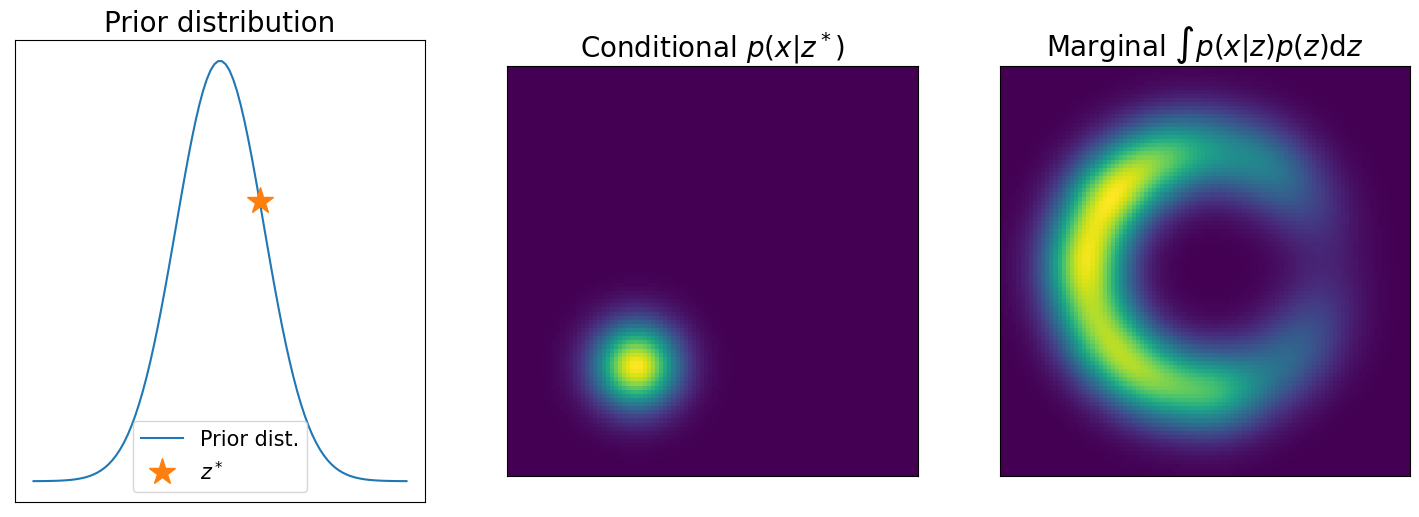

In [17]:
def eval_density(means,sig):
  # means - [N,2]
  # returns - [Ng,Ng]
    if means.ndim==1:
        means = means.reshape([1,-1])
    Ng = 100
    Xg,Yg = np.meshgrid(np.linspace(-5,5,Ng),np.linspace(-5,5,Ng))
    XYg = np.stack([Xg.reshape(-1),Yg.reshape(-1)]).T
    euc_dist = ((np.expand_dims(means,0) - np.expand_dims(XYg,1))**2 / sig**2).sum(-1) # Ngrid,N
    lhood = np.exp(-euc_dist).mean(-1).reshape(Ng,Ng)
    return lhood 

sigmoid = lambda x : 1/(1+np.exp(-x/1)) + 1/(1+np.exp(-x/2)) + 1/(1+np.exp(-x/3))
def f(z):
    theta = np.pi*sigmoid(z)
    return 3*np.stack([np.sin(theta),np.cos(theta)]).T # N,2
sig  = 1.0

fig,axs = plt.subplots(1,3,figsize=(18,6))
# the prior
xs = np.linspace(-3,3,100)
pr_lhoods = np.exp(-xs**2)
axs[0].plot(xs,pr_lhoods)
axs[0].set_xticks([])
axs[0].set_yticks([])
n = 60
z = xs[n]
axs[0].plot(z,pr_lhoods[n],'*',markersize=20)
axs[0].legend(['Prior dist.', r'$z^*$'],fontsize=15)
axs[0].set_title('Prior distribution',fontsize=20)

# the likelihood of a latent sample
mean_z  = f(z)
lhood_z = eval_density(mean_z,sig)
axs[1].imshow(lhood_z)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title(r'Conditional $p(x|z^*)$',fontsize=20)

# the marginal
zs = np.random.randn(500)
means = f(zs)
lhood = eval_density(means,sig)
axs[2].imshow(lhood)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title(r'Marginal $\int p(x|z)p(z)$d$z$',fontsize=20);

$\newcommand{\E}{\mathbb{E}}$

### 3.1. Evidence lower bound (ELBO)
Next, we define a lower bound on the marginal log likelihood. 
This is going to be a function that is always less than or equal to the log likelihood.
We hope that maximizing the lower bound with respect to the parameters of $f$ would also increase the marginal likelihood.
To define this lower bound, we need Jensen’s inequality.

#### Jensen's inequality
Jensen’s inequality simply says that a concave function $g(\cdot)$ of the expectation of a random variable $x$ is greater than or equal to the expectation of the function $g(x)$ of the variable:
$$ g(\E{x}) \geq \E{g(x)}. $$

In our case, this concave function is $\log$:
$$ \log(\E{x}) \geq \E{\log(x)}.$$

If we write everything explicitly, then we have 
$$ \log \left( \int x p(x) \d x \right) \geq  \int \log x ~p(x) \d x. $$

If we consider a deterministic transformation $h(x)$ of $x$ the following also holds:
$$ \log \left( \int h(x) p(x) \d x \right) \geq  \int \log h(x) ~p(x) \d x. $$
This is because $h(x)$ is another random variable with a new distribution. Since we never specified $p(x)$, the relation remains true. (???)

![](https://drive.google.com/uc?export=view&id=1bsmnIvNDzWnNB9qS9GIygHOOBmDdKm23)

To use the Jensen's inequality, we introduce a new distribution $q_\theta(z_n)$ over the latents with parameters $\theta$.
Then we re-write the marginal likelihood:

\begin{align}
\log p(x_n) &= \log \int p(x_n,z_n) \d z_n \\ 
&= \log \int \frac{q_\theta(z_n)}{q_\theta(z_n)} p(x_n,z_n) \d z_n \\ 
&= \log \int q_\theta(z_n) \frac{p(x_n,z_n)}{q_\theta(z_n)}  \d z_n \\ 
&\geq \int q_\theta(z_n) \log\frac{p(x_n,z_n)}{q_\theta(z_n)}  \d z_n \\ 
\end{align}

Next, we first show that the bound is tight if $q_\phi(z_n)$ matches the posterior:

\begin{align}
\int q_\theta(z_n) \log\frac{p(x_n,z_n)}{q_\theta(z_n)} \d z_n &= \int q_\theta(z_n) \log\frac{p(z_n|x_n)p(x_n)}{q_\theta(z_n)} \d z_n  \\ 
&= \int q_\theta(z_n) \log p(x_n) \d z_n + \int q_\theta(z_n) \log\frac{p(z_n|x_n)}{q_\theta(z_n)} \d z_n  \\ 
&= \log p(x_n)  - \texttt{KL}(q_\theta(z_n) \| p(z_n|x_n)).
\end{align}

Finally, we consider the other factorization of the joint $p(z_n,x_n)$:

\begin{align}
\int q_\theta(z_n) \log\frac{p(x_n,z_n)}{q_\theta(z_n)} \d z_n &= \int q_\theta(z_n) \log\frac{p(x_n|z_n)p(z_n)}{q_\theta(z_n)} \d z_n  \\ 
&= \int q_\theta(z_n) \log p(x_n|z_n) \d z_n + \int q_\theta(z_n) \log\frac{p(z_n)}{q_\theta(z_n)} \d z_n  \\ 
&= \E[q_\theta(z_n)]{\log p(x_n|z_n)} - \texttt{KL}(q_\theta(z_n) \| p(z_n)).
\end{align}

Note that our goal is to maximize this expression.
Hence, the first "reconstruction" term encourages such $q_\theta$ distributions that lead to high (expected) likelihood $p(x_n|z_n)$. 
The second term, which we aim to minimize, encourages $q_\theta$ to be simple (close to prior); hence, acts as a regularizer.


#### Specifying the variational distribution
In the VAE algorithm, $q_\theta(z_n)$ is approximated by a neural network as s function of the input data $x_n$:

$$ q_\theta(z_n | x_n) = \N \left( \texttt{NN}_1(x_n), \texttt{NN}_2(x_n) \right) $$

![](figs/jensen.png)

In practice the second KL term is available in closed-form when both $q(z_n|x_n)$ and $p(z_n)$ are Gaussians.
However, the first integral is intractable since $p(x_n|z_n)$ is non-linear (decoder network).
Since it is an expectation, we can always approximate it by sampling:

\begin{align}
\E[q_\theta(z_n|x_n)]{\log p(x_n|z_n)} \approx \frac{1}{L} \sum_{\ell=1}^L \log p(x_n|z_n^{(\ell)}), \quad \text{where} \quad z_n^{(\ell)} \sim q_\theta(z_n|x_n),
\end{align}
which is also known as Monte Carlo averaging.

#### Reparameterization trick
Finally, we explain a rather complicated difficulty.
That is, we need to compute the partial derivative $\frac{\partial \log p(x_n|z_n^{(\ell)})}{\partial \theta}$ of the log-likelihood wrt to the samples $z_n^{(\ell)}$.
Yet we have not specified how to compute partial derivatives of samples from a Gaussian distribution.
For this, we use the trick called *reparameterization trick*, which simply says that the following two expressions are equivalent:


\begin{align}
\E[q_\theta(z_n|x_n)]{\log p(x_n|z_n)} &= \E[\epsilon \sim \N(0,I)]{\log p(x_n|\mu_{z_n}+\Sigma_{z_n}^{-1}\epsilon)} \\
\E[\N \left( \texttt{NN}_1(x_n), \texttt{NN}_2(x_n) \right)]{\log p(x_n|z_n)} &= \E[\epsilon \sim \N(0,I)]{\log p(x_n|\texttt{NN}_1(x_n)+\texttt{NN}_2(x_n)^{-1}\epsilon)} \\
\end{align}

or more explicity

\begin{align}
\log p(x_n|z_n^{(\ell)}), &\quad z_n^{(\ell)} \sim \N \left( \texttt{NN}_1(x_n), \texttt{NN}_2(x_n) \right)  \\
\log p(x_n|z_n^{(\ell)}), &\quad z_n^{(\ell)} = \texttt{NN}_1(x_n) + (\texttt{NN}_2(x_n))^{-1} \epsilon , \quad \epsilon \sim \N(0,I).
\end{align}

That is, we simply reparameterize the distribution.





## VAE algorithm

Overall, we obtain the following algorithm:

\begin{align}
\text{Input:} ~~ &x \\
\mu_{z} &= \texttt{NN}_1(x) \\ 
\Sigma_{z} &= \texttt{NN}_2(x) \\
\epsilon &\sim \N(0,I) \\
z &= \mu_{z}+\Sigma_{z}^{-1}\epsilon \\
\text{Output:} ~~\hat{x} &= \texttt{NN}_3(z) \\
\max ~~& p(x|\hat{x}) - \texttt{KL}(\N(\mu_{z},\Sigma_{z}) \| \N(0,I))
\end{align}


![](figs/vae.png)
